In [377]:
import sqlite3
from rosidl_runtime_py.utilities import get_message
from rclpy.serialization import deserialize_message

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

In [378]:
class BagFileParser():
    def __init__(self, bag_file):
        self.conn = sqlite3.connect(bag_file)
        self.cursor = self.conn.cursor()

        ## create a message type map
        topics_data = self.cursor.execute("SELECT id, name, type FROM topics").fetchall()
        self.topic_type = {name_of:type_of for id_of,name_of,type_of in topics_data}
        self.topic_id = {name_of:id_of for id_of,name_of,type_of in topics_data}
        self.topic_msg_message = {name_of:get_message(type_of) for id_of,name_of,type_of in topics_data}

    def __del__(self):
        self.conn.close()

    # Return [(timestamp0, message0), (timestamp1, message1), ...]
    def get_messages(self, topic_name):

        topic_id = self.topic_id[topic_name]
        # Get from the db
        rows = self.cursor.execute("SELECT timestamp, data FROM messages WHERE topic_id = {}".format(topic_id)).fetchall()
        # Deserialise all and timestamp them
        return [ (timestamp,deserialize_message(data, self.topic_msg_message[topic_name])) for timestamp,data in rows]

In [379]:
n = "caja3"
bag_file = 'Recordings/' + n + '/' + n + '_0.db3'

parser = BagFileParser(bag_file)

trajectory = parser.get_messages("/object/pose")
robot1_pose = parser.get_messages("/robot1/pose")
robot2_pose = parser.get_messages("/robot2/pose")
robot1_cmd_vel = parser.get_messages("/robot1/cmd_vel")
robot2_cmd_vel = parser.get_messages("/robot2/cmd_vel")

In [380]:
trajectory[0]

(1715808907610829237,
 geometry_msgs.msg.Pose(position=geometry_msgs.msg.Point(x=-0.011188682337468796, y=0.006111999799698498, z=0.2184176629014395), orientation=geometry_msgs.msg.Quaternion(x=4.21114253555447e-05, y=-0.002934956405763965, z=-0.006065144369384785, w=0.999977298882981)))

In [381]:
path = [[w[1].position.x, w[1].position.y] for w in trajectory]

robot1_path = []
for p in robot1_pose:
    if [p[1].orientation.x, p[1].orientation.y, p[1].orientation.z, p[1].orientation.w] != [0,0,0,0]:
        #p[1].orientation.w = 1.0
        r = R.from_quat([p[1].orientation.x, p[1].orientation.y, p[1].orientation.z, p[1].orientation.w])
        orient = r.as_rotvec()[2]
        robot1_path.append([p[1].position.x, p[1].position.y, orient])

robot2_path = []
for p in robot2_pose:
    if [p[1].orientation.x, p[1].orientation.y, p[1].orientation.z, p[1].orientation.w] != [0,0,0,0]:
        #p[1].orientation.w = 1.0
        r = R.from_quat([p[1].orientation.x, p[1].orientation.y, p[1].orientation.z, p[1].orientation.w])
        orient = r.as_rotvec()[2]
        robot2_path.append([p[1].position.x, p[1].position.y, orient])


robot1_cmd_vel = [[w[1].linear.x, w[1].linear.y, w[1].angular.z] for w in robot1_cmd_vel]
robot2_cmd_vel = [[w[1].linear.x, w[1].linear.y, w[1].angular.z] for w in robot2_cmd_vel]

### Complete plot

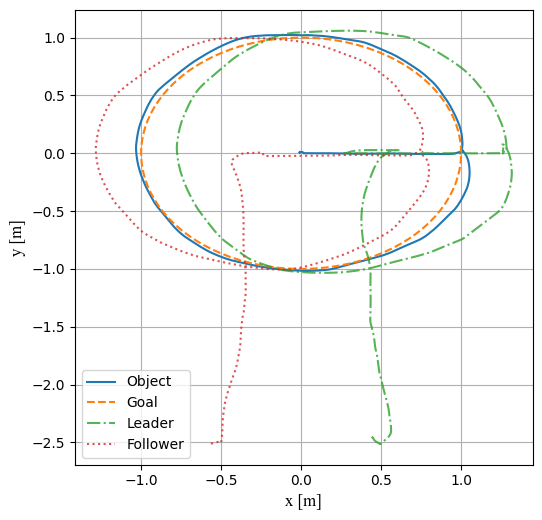

In [382]:
path = np.array(path)
robot1_path = np.array(robot1_path)
robot2_path = np.array(robot2_path)
points = np.linspace(0, 2*np.pi, 100)

cm = 1/2.54
plt.figure("Fig", figsize=(15*cm,15*cm))
plt.plot(path[:,0], path[:,1])
plt.plot(np.cos(points), np.sin(points), "--")
plt.plot(robot1_path[:,0], robot1_path[:,1], "-.", alpha=0.8)
plt.plot(robot2_path[:,0], robot2_path[:,1], ":", alpha=0.8)
plt.xlabel("x [m]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.ylabel("y [m]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.legend(["Object", "Goal", "Leader", "Follower"])
plt.grid()
#plt.savefig("Imagenes articulo/fig_caja_t2.pdf")

### Trajectory states plots

caja t1:
- start = 405
- end = 90

caja t2:
- start = 370
- end = 50

Euclidean error = 0.10211912648119648


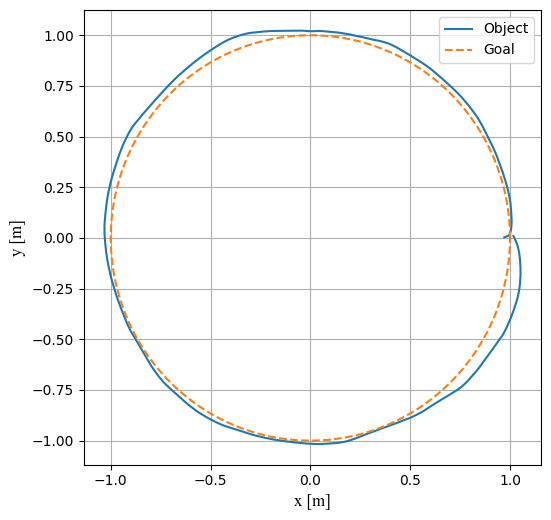

In [383]:
start = 405
end = 90
path = np.array(path)[-start:-end,:]
robot1_path = np.array(robot1_path)[-start:-end,:]
robot2_path = np.array(robot2_path)[-start:-end,:]
points = np.linspace(0, 2*np.pi, path.shape[0])

d_error = np.sum(np.sqrt((path[:,0] - np.cos(points))**2 + (path[:,1] - np.sin(points))**2))/path.shape[0]
print("Euclidean error =", d_error)

plt.figure("Fig", figsize=(15*cm,15*cm))
plt.plot(path[:,0], path[:,1])
plt.plot(np.cos(points), np.sin(points), "--")
# plt.plot(robot1_path[:,0], robot1_path[:,1], alpha=0.4)
# plt.plot(robot2_path[:,0], robot2_path[:,1], alpha=0.4)
plt.xlabel("x [m]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.ylabel("y [m]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.legend(["Object", "Goal"])
plt.grid()

X error = 0.07132429254253228


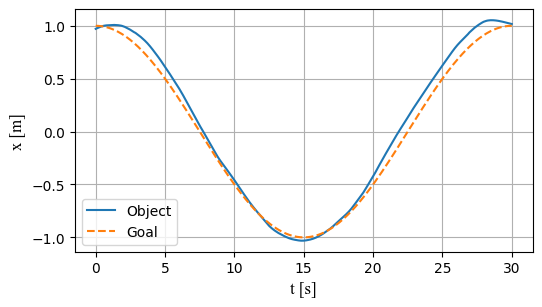

In [384]:
t = np.linspace(0, 30, path.shape[0])
points = np.linspace(0, 2*np.pi, path.shape[0])

x_error = np.sum(np.abs(path[:,0] - np.cos(points)))/path.shape[0]
print("X error =", x_error)

plt.figure("Fig", figsize=(15*cm,8*cm))
plt.plot(t, path[:,0])
plt.plot(t, np.cos(points), "--")
plt.xlabel("t [s]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.ylabel("x [m]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.legend(["Object", "Goal"])
plt.grid()
#plt.savefig("Imagenes articulo/fig_caja_x_t2.pdf", bbox_inches="tight")

Y error = 0.06037226563894202


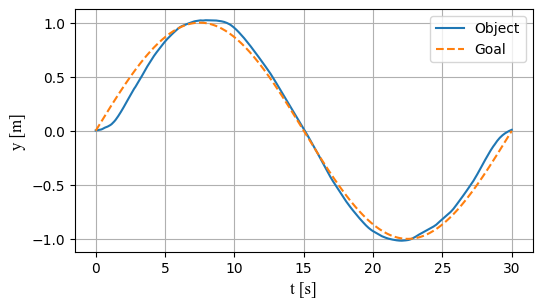

In [385]:
y_error = np.sum(np.abs(path[:,1] - np.sin(points)))/path.shape[0]
print("Y error =", y_error)

plt.figure("Fig", figsize=(15*cm,8*cm))
plt.plot(t, path[:,1])
plt.plot(t, np.sin(points), "--")
plt.xlabel("t [s]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.ylabel("y [m]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.legend(["Object", "Goal"])
plt.grid()
#plt.savefig("Imagenes articulo/fig_caja_y_t2.pdf", bbox_inches="tight")

### Robots plots

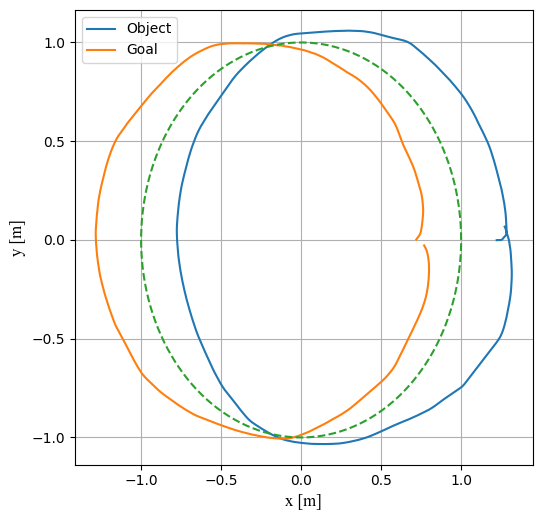

In [386]:
plt.figure("Fig", figsize=(15*cm,15*cm))
plt.plot(robot1_path[:,0], robot1_path[:,1])
plt.plot(robot2_path[:,0], robot2_path[:,1])
plt.plot(np.cos(points), np.sin(points), "--")
plt.xlabel("x [m]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.ylabel("y [m]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.legend(["Object", "Goal"])
plt.grid()
#plt.savefig("Imagenes articulo/fig_caja.pdf")

d robots error = 0.01260561421872398


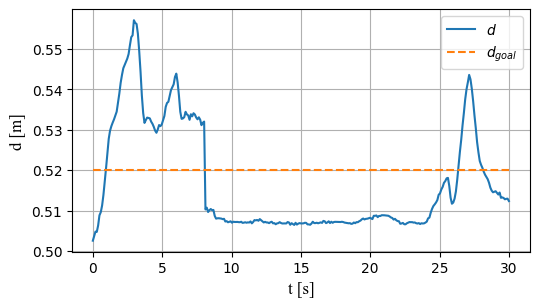

In [387]:
d_robots = np.sqrt((robot1_path[:,0] - robot2_path[:,0])**2 + (robot1_path[:,1] - robot2_path[:,1])**2)

d_robots_error = np.sum(np.abs(d_robots - 0.52))/path.shape[0]
print("d robots error =", d_robots_error)

plt.figure("Fig", figsize=(15*cm,8*cm))
plt.plot(t, d_robots)
plt.plot(t, 0.52*np.ones(path.shape[0]), "--")
plt.xlabel("t [s]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.ylabel("d [m]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.grid()
plt.legend(["$d$", "$d_{goal}$"])
plt.savefig("Imagenes articulo/fig_robots_d.pdf", bbox_inches="tight")

#### Trajectory 1

theta L error = 0.08186809707611814


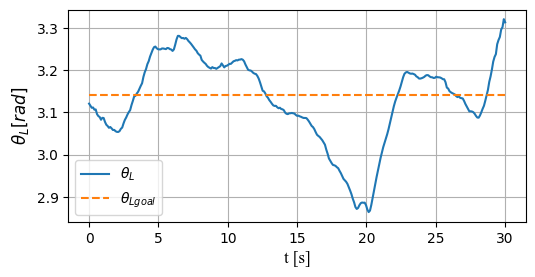

In [388]:
robot1_path[robot1_path[:,2] < 0, 2] += 2*3.1416

theta_L_error = np.sum(np.abs(robot1_path[:,2] - 3.14*np.ones(path.shape[0])))/path.shape[0]
print("theta L error =", theta_L_error)

plt.figure("Fig", figsize=(15*cm,7*cm))
plt.plot(t, robot1_path[:,2])
plt.plot(t, 3.14*np.ones(path.shape[0]), "--")
plt.xlabel("t [s]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.ylabel(r"$\theta_L [rad]$", {"fontsize": 12, "fontname": "Times New Roman"})
plt.grid()
plt.legend([r"$\theta_L$", r"$\theta_{Lgoal}$"])
#plt.savefig("Imagenes articulo/fig_theta_L.pdf", bbox_inches="tight")

theta F error = 0.08661620623628681


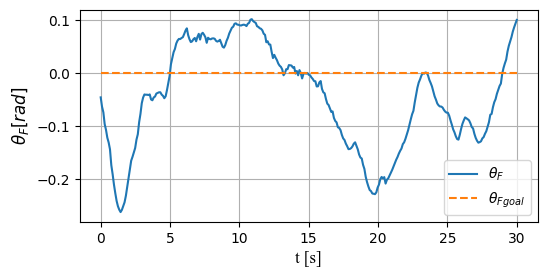

In [389]:
theta_F_error = np.sum(np.abs(robot2_path[:,2] - np.zeros(path.shape[0])))/path.shape[0]
print("theta F error =", theta_F_error)

plt.figure("Fig", figsize=(15*cm,7*cm))
plt.plot(t, robot2_path[:,2])
plt.plot(t, np.zeros(path.shape[0]), "--")
plt.xlabel("t [s]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.ylabel(r"$\theta_F [rad]$", {"fontsize": 12, "fontname": "Times New Roman"})
plt.grid()
plt.legend([r"$\theta_F$", r"$\theta_{Fgoal}$"])
#plt.savefig("Imagenes articulo/fig_theta_F.pdf", bbox_inches="tight")

alpha error = 0.0597978258084108


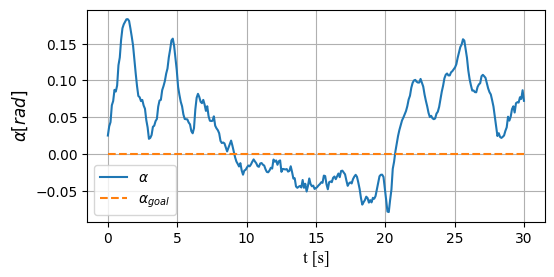

In [390]:
alpha_error = np.sum(np.abs((robot1_path[:,2] - np.pi) - robot2_path[:,2]))/path.shape[0]
print("alpha error =", alpha_error)

plt.figure("Fig", figsize=(15*cm,7*cm))
plt.plot(t, (robot1_path[:,2] - np.pi) - robot2_path[:,2])
plt.plot(t, np.zeros(path.shape[0]), "--")
plt.xlabel("t [s]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.ylabel(r"$\alpha [rad]$", {"fontsize": 12, "fontname": "Times New Roman"})
plt.grid()
plt.legend([r"$\alpha$", r"$\alpha_{goal}$"])
#plt.savefig("Imagenes articulo/fig_alpha.pdf", bbox_inches="tight")

#### Trajectory 2

theta L error = 1.981462529784667


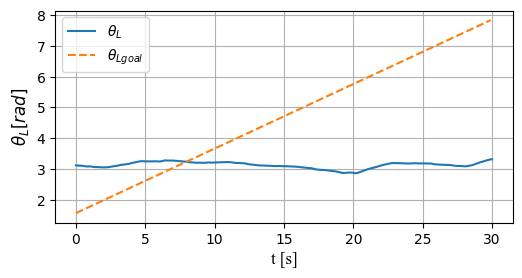

In [391]:
waypoints = np.array([np.cos(points), np.sin(points)])
waypoints = list(waypoints.T)

orient = []

for w in waypoints:

    theta = np.arctan2(w[1],w[0]) + np.pi/2

    orient.append(theta)

orient = np.array(orient)
orient = ((orient + np.pi)%(2*np.pi)) - np.pi
robot1_path[:,2] = ((robot1_path[:,2] + np.pi)%(2*np.pi)) - np.pi

orient[orient < 1.57] += 2*3.1416
robot1_path[robot1_path[:,2] < 1.57, 2] += 2*3.1416

theta_L_error = np.sum(np.abs(robot1_path[:-1,2] - orient[:-1]))/orient.shape[0]
print("theta L error =", theta_L_error)

plt.figure("Fig", figsize=(15*cm,7*cm))
plt.plot(t, robot1_path[:,2])
plt.plot(t[:-1], orient[:-1], "--")
#plt.plot(t, orient, "--")
plt.xlabel("t [s]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.ylabel(r"$\theta_L [rad]$", {"fontsize": 12, "fontname": "Times New Roman"})
plt.grid()
plt.legend([r"$\theta_L$", r"$\theta_{Lgoal}$"])
#plt.savefig("Imagenes articulo/fig_theta_L_t2.pdf", bbox_inches="tight")

theta F error = 1.9723154068669286


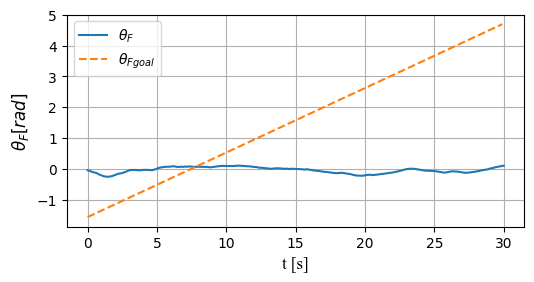

In [392]:
orient = orient - 3.14
orient = ((orient + np.pi)%(2*np.pi)) - np.pi

orient[orient < -1.57] += 2*3.1416
robot2_path[robot2_path[:,2] < -1.57, 2] += 2*3.1416

theta_F_error = np.sum(np.abs(robot2_path[:-1,2] - orient[:-1]))/orient.shape[0]
print("theta F error =", theta_F_error)

plt.figure("Fig", figsize=(15*cm,7*cm))
plt.plot(t, robot2_path[:,2])
plt.plot(t[:-1], orient[:-1], "--")
#plt.plot(t, orient, "--")
plt.xlabel("t [s]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.ylabel(r"$\theta_F [rad]$", {"fontsize": 12, "fontname": "Times New Roman"})
plt.grid()
plt.legend([r"$\theta_F$", r"$\theta_{Fgoal}$"])
#plt.savefig("Imagenes articulo/fig_theta_F_t2.pdf", bbox_inches="tight")

alpha error = 0.05980155731835712


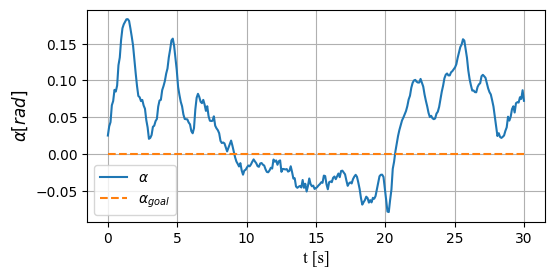

In [393]:
alpha_error = np.sum(np.abs((robot1_path[:,2] - np.pi) - robot2_path[:,2]))/orient.shape[0]
print("alpha error =", alpha_error)

plt.figure("Fig", figsize=(15*cm,7*cm))
plt.plot(t, (robot1_path[:,2] - np.pi) - robot2_path[:,2])
plt.plot(t, np.zeros(path.shape[0]), "--")
plt.xlabel("t [s]", {"fontsize": 12, "fontname": "Times New Roman"})
plt.ylabel(r"$\alpha [rad]$", {"fontsize": 12, "fontname": "Times New Roman"})
plt.grid()
plt.legend([r"$\alpha$", r"$\alpha_{goal}$"])
plt.savefig("Imagenes articulo/fig_alpha_t2.pdf", bbox_inches="tight")